In [1]:
import random
import math
import numpy as np

K = 10000  # Total number of coins in the system
x = 0.3  # Total wealth of adversary as a proportion of total coins
F = {} # 


def eval_F(num_rounds, wealth=x, total_coins=K):
    if wealth not in F:
        print "We have not even computed anything for the wealth at value " + str(wealth)
        F[wealth] = [wealth]
        
        # Calculate the case for two rounds
        exp_rew = 0
        for k in range(int(wealth * total_coins) + 1):
            if k > 0:
                exp_rew = exp_rew + P(k, wealth, total_coins) * (1+(k*wealth*total_coins)/(k*wealth*total_coins + total_coins*(1-wealth)))
            else:
                exp_rew = exp_rew + P(k, wealth, total_coins)*wealth
        F[wealth].append(exp_rew/2)
    
    if len(F[wealth]) >= num_rounds:
        print "We have already computed this for " + str(num_rounds)
        return F[wealth][num_rounds - 1]
    else:
        print "We have not computed this so for " + str(num_rounds) + " we are computing it now."
        while (len(F[wealth]) < num_rounds - 1):
            print "We need to evaluate F for some more rounds before we go on."
            eval_F(len(F[wealth]) + 1, wealth, total_coins)

        assert len(F[wealth]) == num_rounds - 1

        exp_rew = 0

        for k in range(int(wealth * total_coins) + 1):
            max_sub_rew = -1
            for _ in range(k):
                rand_rew = reward_rand(num_rounds - 1, wealth, total_coins)
                max_sub_rew = max(max_sub_rew, rand_rew)

            exp_rew = exp_rew + P(k, wealth, total_coins) * max(1 + max_sub_rew, F[wealth][num_rounds - 2])

        F[wealth].append(exp_rew / num_rounds)
        return exp_rew / num_rounds


def P(k, x, K):
    log_ans = 0
    Kx = int(K * x)
    log_ans = log_ans + math.log(1 - x)
    for i in range(1, K - k):
        log_ans = log_ans + math.log(i)

    for i in range(Kx - k + 1, Kx + 1):
        log_ans = log_ans + math.log(i)

    for i in range(1, K):
        log_ans = log_ans - math.log(i)

    return math.e ** log_ans


# Wealth as a fraction of total coins
def reward_rand(rounds_rem, wealth=x, total_coins=K):
    Kx = int(total_coins * wealth)
    hashes = np.random.uniform(0, 1, Kx)

    if rounds_rem == 1:
        return (1 - min(hashes)) ** (total_coins * (1 - wealth))

    # Calculate expected reward obtained using the coin to win.

    max_reward = -1

    for i in range(Kx):

        reward_with_coin = ((1 - hashes[i]) ** (total_coins * (1 - wealth))) * (
            1 + reward_rand(rounds_rem - 1, wealth, total_coins)) + (1 - (1 - hashes[i]) ** (
            total_coins * (1 - wealth))) * eval_F(rounds_rem - 1, wealth, total_coins)

        max_reward = max(max_reward, reward_with_coin)

        assert (max_reward >= 0)

    rew = max(reward_with_coin, eval_F(rounds_rem - 1, wealth, total_coins))

    assert (rew <= rounds_rem) and (rew >= wealth * (rounds_rem-1))
    return rew


In [20]:
def eval_F_gen(num_rounds, wealth, total_coins):
    round_idx = num_rounds - 1
    owned_coins = int(wealth * total_coins)
    
    if wealth not in F:
#         print "We have not even computed anything for the wealth at value " + str(wealth)
        F[wealth] = [wealth]
        
        # Calculate the case for two rounds
        exp_rew = 0
        for k in range(int(wealth * total_coins) + 1):
            if k > 0:
                exp_rew = exp_rew + P(k, wealth, total_coins) * (1+(k*wealth*total_coins)/(k*wealth*total_coins + total_coins*(1-wealth)))
            else:
                exp_rew = exp_rew + P(k, wealth, total_coins)*wealth
        F[wealth].append(exp_rew/2)
    
    if len(F[wealth]) >= num_rounds:
#         print "We have already computed this for " + str(num_rounds)
        return F[wealth][num_rounds - 1]
    else:
        while (len(F[wealth]) < num_rounds - 1):
#             print "We need to evaluate F for some more rounds before we go on."
            eval_F_gen(len(F[wealth]) + 1, wealth, total_coins)

        assert len(F[wealth]) == num_rounds - 1
        
        best_rew = np.zeros(owned_coins+1)
        
        for k in range(owned_coins + 1):
            if k == 0:
                best_rew[k] = eval_F_gen(num_rounds-1, wealth, total_coins) * (num_rounds - 1)
            else:
#                 print("Number of top coins: " + str(k))
                game_struct = [k]
                probs = [np.ones(k)]
                rewards = [np.zeros(k)]
                for i in range(num_rounds-1):
                    game_struct.append(owned_coins)
                    prob = np.power(np.random.random_sample(tuple(game_struct)), total_coins - owned_coins)
                    probs.append(prob)
                    if i == num_rounds-2:
                        rewards.append(prob)
                    else:
                        rewards.append(np.zeros(tuple(game_struct)))

#                 print("probs")
#                 print(probs)

#                 print("rewards")
#                 print(rewards)

                for rd in range(num_rounds-2, 0, -1):
                    prbs = probs[rd]
                    prbs_comp = np.subtract(1, prbs)
                    rwd_nxt = rewards[rd + 1]
                    rwd_nxt_max = np.amax(rwd_nxt, axis=rd+1)
                    f_next = eval_F_gen(num_rounds-rd-1, wealth, total_coins) * (num_rounds-rd-1)
                    rwd = (
                        np.maximum(
                            np.add(
                                np.multiply(
                                    prbs,
                                    np.add(1, rwd_nxt_max)
                                ),
                                np.multiply(
                                    prbs_comp,
                                    f_next
                                )
                            ),
                            f_next
                        )
                    )
                    rewards[rd] = rwd

                rewards[0] = np.maximum(
                    np.add(1, np.amax(rewards[1], axis=1)),
                    eval_F_gen(num_rounds-1, wealth, total_coins) * (num_rounds - 1)
                )
                best_rew[k] = np.max(rewards[0])

#                 print("Post Calculations:")
#                 print("probs")
#                 print(probs)

#                 print("rewards")
#                 print(rewards)

        p_vec = P_vec(wealth, total_coins)
#         print("best_rew")
#         print(best_rew)
#         print("p_vec")
#         print(p_vec)
        F[wealth].append(np.dot(best_rew, p_vec)/num_rounds)

def P_vec(x, K):
    p_vec = np.zeros(int(x*K) + 1)
    for k in range(int(x*K) + 1):
        p_vec[k] = P(k, x, K)
    return p_vec

# # Test Method
# num_rounds = 1
# wealth = 0.1
# total_coins = 10
# F = {}
# eval_F_gen(num_rounds, wealth, total_coins)

0.1

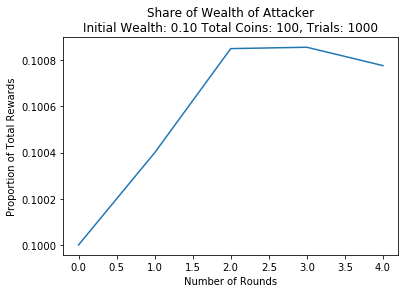

In [40]:
# Run Experiments and Plot Results

num_rounds = 5
wealth = 0.1
total_coins = 100
num_trials = 1000

avg_F = np.zeros(num_rounds)
for _ in range(num_trials):
    F = {}
    eval_F_gen(num_rounds, wealth, total_coins)
    avg_F = avg_F + np.array(F[wealth])/num_trials
    
#     print(F[wealth])
#     print(avg_F)

import matplotlib.pyplot as plt
plt.plot(range(num_rounds), avg_F)
plt.xlabel("Number of Rounds")
plt.ylabel("Proportion of Total Rewards")
plt.title("Share of Wealth of Attacker\nInitial Wealth: %.2f Total Coins: %d, Trials: %d" % (wealth, total_coins, num_trials))
plt.show()